In [2]:
import pandas as pd
from helpers.read_eco_data import preprocess as pp


In [3]:
from glob import glob

In [4]:
df = pp('../esg_data/esg_data.json')

In [5]:
data_list = glob('../data/*')
data_list = [x.split('\\')[1].split('.')[0] for x in data_list]

In [6]:
df

,ticker,eco_score
0,3MINDIA,0.163942
1,5PAISA,0.580448
2,AWL,0.219065
3,ATGL,0.255459
4,ADANIGR,0.050062
...,...,...
367,FEDERALBNK,0.280893
368,KTKBANK,0.065846
369,KARURVYSYA,0.093258
370,LAKSHVILAS,0.089197


In [7]:
df = df.drop(df[df['ticker'].apply(lambda x: x not in data_list)].index)
df = df.reset_index()
df.drop(['index'], axis =1 , inplace = True)

In [8]:
coint_df = pd.DataFrame()

for ticker in df['ticker']: 
    data = pd.read_json('../data/'+ str(ticker) + '.json')
    
    data['t'] = pd.to_datetime(data['t'], unit = 's')

    temp = pd.DataFrame({
        'Date' : data['t'], 
        str(ticker) : data['c'] 
    })

    if coint_df.empty: 
        coint_df = temp
    else:
        coint_df = pd.merge(coint_df, temp, on = 'Date', how = 'outer')

In [9]:
coint_df.drop([3259], axis = 0, inplace=True)


In [10]:
in_sample = coint_df.drop(coint_df[coint_df['Date'].apply(lambda x: x > pd.to_datetime('01-01-2023'))].index)


In [11]:

# Find the index of the last row containing at least one NaN value
last_nan_index = coint_df[coint_df.isna().any(axis=1)].last_valid_index()

# # Use the index to retrieve the corresponding row
# last_nan_row = df.loc[last_nan_index]

print(last_nan_index)

3258


In [12]:
in_sample.drop(['Date'], axis = 1, inplace=True)

In [13]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen as cj 

In [14]:
columns_with_nan = in_sample.columns[in_sample.isna().any()]

In [15]:
df_cleaned = in_sample.drop(columns=columns_with_nan)

In [16]:

from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform
df_standardized = scaler.fit_transform(df_cleaned)

# Convert back to DataFrame
df_standardized = pd.DataFrame(df_standardized, columns=df_cleaned.columns)

print("Original DataFrame:")


print("\nStandardized DataFrame:")


Original DataFrame:

Standardized DataFrame:


In [17]:
# Calculate correlation matrix
correlation_matrix = df_cleaned.corr()

lst = []
# Find max correlation in each row, excluding diagonal elements
max_corr_values = []
for row_index, row in correlation_matrix.iterrows():
    max_corr = row.drop(index=row_index).max()

    for i in range(len(row)): 
        if abs(row[i]) > 0.95 and correlation_matrix.columns[i] != row_index: 
            lst.append([row_index, correlation_matrix.columns[i], row[i]] )


print(len(lst))
for l in lst:
    print(l)

304
['3MINDIA', 'BRITANNIA', 0.9718198098190032]
['3MINDIA', 'GODREJCP', 0.9519950234305117]
['3MINDIA', 'HDFCBANK', 0.9586682933173925]
['3MINDIA', 'KOTAKBANK', 0.9546795679829759]
['3MINDIA', 'PGHH', 0.9547669758643443]
['ADANIPORTS', 'CHOLAFIN', 0.9707089823337407]
['ADANIPORTS', 'HAVELLS', 0.9538543556513378]
['ADANIPORTS', 'ICICIBANK', 0.9548189617537055]
['ADANIPORTS', 'J&KBANK', 0.9537697918537986]
['ADANIPORTS', 'JSWSTEEL', 0.9537697918537986]
['AEGISCHEM', 'MRF', 0.9575465940824635]
['ASIANPAINT', 'BAJFINANCE', 0.9813136063096033]
['ASIANPAINT', 'BAJAJFINSV', 0.96947495809187]
['ASIANPAINT', 'BALKRISIND', 0.9684017176410309]
['ASIANPAINT', 'CHOLAFIN', 0.9617280414581474]
['ASIANPAINT', 'COFORGE', 0.9515755605897194]
['ASIANPAINT', 'HAVELLS', 0.9799480688951411]
['ASIANPAINT', 'HCLTECH', 0.9669291765033783]
['ASIANPAINT', 'HONAUT', 0.9674633375004905]
['ASIANPAINT', 'ICICIBANK', 0.9576283058985484]
['ASIANPAINT', 'JUBLFOOD', 0.9552532495446286]
['ASIANPAINT', 'NESTLEIND', 0.959

In [18]:
import statsmodels.api as sm

def mean_revert(df, pair): 
    new_df = pd.DataFrame({
        'stock 1' : df[pair[0]], 
        'stock 2' : df[pair[1]]  
    })

    result = cj(new_df, 0, 2)
    # Print Eigenvalues
    print("Eigenvalues:")
    print(result.eig)

    # Print Trace Statistics
    print("\nTrace Statistics:")
    print(result.lr1)

    # Print Maximum Eigenvalue Statistics
    print("\nMaximum Eigenvalue Statistics:")
    print(result.lr2)

    # Print Critical Values for Trace Statistics
    print("\nCritical Values for Trace Statistics (90%, 95%, 99%):")
    print(result.cvm)

    # Print Critical Values for Maximum Eigenvalue Statistics
    print("\nCritical Values for Maximum Eigenvalue Statistics (90%, 95%, 99%):")
    print(result.cvm)


In [19]:
def get_hedge(df, pair): 
    new_df = pd.DataFrame({
        's1' : df[pair[0]], 
        's2' : df[pair[1]]  
    })

    model = sm.OLS(new_df['s1'], new_df['s2'])
    res = model.fit()

    # print(res.summary())
    return res.params['s2']


In [20]:
import matplotlib.pyplot as plt

In [21]:
def plot_spread(df, pair):
    hr = get_hedge(df, pair)
    spread = df[pair[0]] - hr*df[pair[1]]
    plt.plot(spread)
    plt.show()

In [22]:
out_sample = coint_df.iloc[coint_df[coint_df['Date'] > pd.to_datetime('01-01-2023')].index]
out_sample.reset_index(inplace=True)


In [23]:
out_sample.drop(columns=['index'],inplace = True)

C:\Users\esnd1\AppData\Local\Temp\ipykernel_10484\1585560249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_sample.drop(columns=['index'],inplace = True)


In [24]:
out_sample

,Date,3MINDIA,5PAISA,AWL,ATGL,ADANIPORTS,ADANIPOWER,AEGISCHEM,ALLCARGO,AMARAJABAT,...,TCIEXP,TEAMLEASE,TECHM,TECHNOE,TEJASNET,TEXRAIL,FEDERALBNK,KTKBANK,KARURVYSYA,THERMAX
0,2023-01-02,21505.70,314.95,603.95,3550.60,822.30,298.15,345.70,305.57,574.80,...,1818.05,2525.70,1009.50,339.80,606.40,57.95,137.70,154.30,110.60,1961.30
1,2023-01-03,21602.00,320.30,600.30,3598.65,820.45,294.75,344.35,303.20,575.80,...,1796.50,2527.15,1023.80,343.85,601.80,59.20,137.75,158.00,112.00,1955.55
2,2023-01-04,22050.40,314.40,584.35,3477.30,810.00,286.60,342.95,306.92,573.15,...,1794.85,2485.05,1020.30,343.25,593.80,59.10,136.40,155.60,111.10,1951.15
3,2023-01-05,22388.00,313.00,573.95,3633.70,819.60,288.75,342.20,310.31,575.45,...,1823.35,2488.45,1011.65,362.60,590.35,59.75,136.70,154.95,111.25,1950.95
4,2023-01-06,22294.40,312.30,568.35,3555.40,806.10,283.40,341.85,301.43,585.90,...,1816.00,2459.80,986.15,363.50,582.35,58.20,134.60,150.40,110.05,1963.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,2023-08-14,28680.35,449.35,375.80,635.60,787.15,286.10,364.55,284.30,613.50,...,1414.40,2293.65,1219.75,463.25,813.30,115.50,133.00,225.85,121.55,2563.55
153,2023-08-16,28746.55,449.40,370.10,635.55,776.10,279.90,358.85,277.15,616.50,...,1425.45,2253.10,1227.85,476.35,843.00,118.80,132.20,225.00,119.05,2585.60
154,2023-08-17,29174.65,442.80,368.10,633.70,809.65,286.55,352.85,273.55,622.30,...,1422.80,2238.65,1231.75,493.00,853.15,118.35,134.60,228.70,119.80,2579.10
155,2023-08-18,29126.70,431.25,381.95,654.50,835.90,304.60,355.30,265.35,627.65,...,1413.85,2192.70,1210.80,483.15,843.90,113.95,134.15,227.65,116.85,2599.50


In [25]:
def check_spread(in_df, out_df, pair): 
    hr = get_hedge(in_df, pair)
    spread = out_df[pair[0]] - hr*out_df[pair[1]]
    plt.plot(spread)
    plt.show()

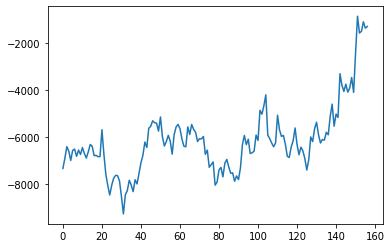

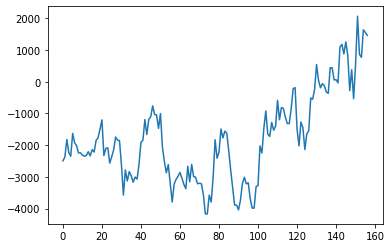

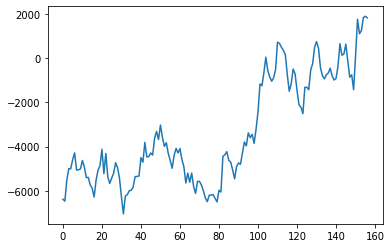

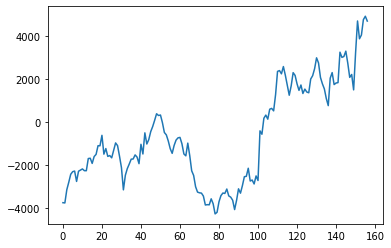

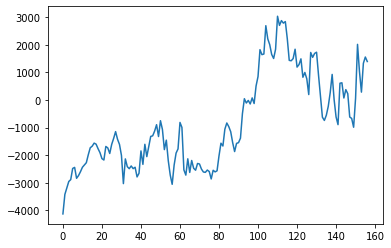

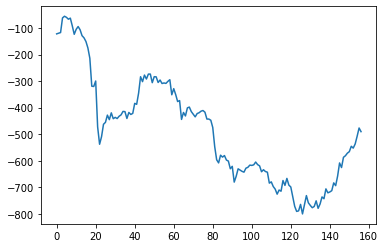

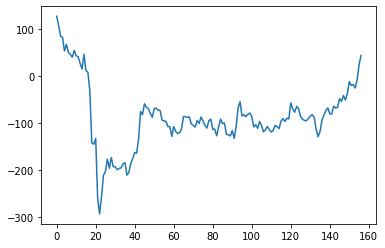

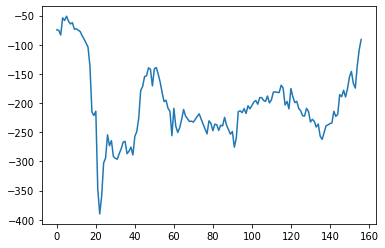

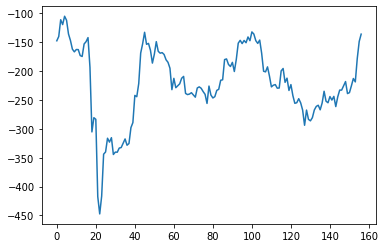

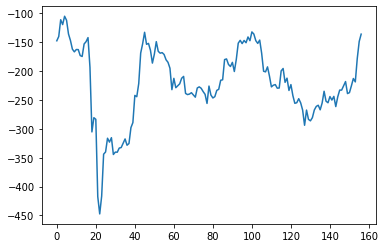

In [27]:
for i in range(10): 
    check_spread(df_cleaned, out_sample, lst[i])